In [1]:
import ase.io
import chemiscope
import matplotlib.pyplot as plt
import numpy as np

structures = ase.io.read("pbesol_Au_alloys_MAD_compatible.xyz", format='extxyz', index=':')
eval_structures = ase.io.read("petmad-output.xyz", format='extxyz', index=':')
ft_eval_structures = ase.io.read("ft-output.xyz", format='extxyz', index=':')
#chemiscope.explore(structures)
        


In [114]:
structures = ase.io.read("../../../pbesol_alloys_MAD_compatible.xyz", format='extxyz', index=':')


In [117]:
c = Counter(mask)
print(c)

Counter({False: 44736, True: 1139})


In [2]:
from collections import Counter


typ = [np.unique(atom.get_chemical_symbols()) for atom in structures]
typ_flatten = [t for i in typ for t in i]
counts = Counter(typ_flatten)
print(counts)

Counter({np.str_('Au'): 1218, np.str_('Pd'): 16, np.str_('Bi'): 16, np.str_('Hg'): 16, np.str_('Se'): 16, np.str_('Sc'): 16, np.str_('Br'): 16, np.str_('As'): 16, np.str_('Os'): 16, np.str_('Cu'): 16, np.str_('Zr'): 16, np.str_('Rb'): 16, np.str_('Pt'): 16, np.str_('Co'): 16, np.str_('P'): 16, np.str_('In'): 16, np.str_('Pb'): 16, np.str_('Y'): 16, np.str_('Cl'): 16, np.str_('Nd'): 16, np.str_('K'): 16, np.str_('Ni'): 16, np.str_('H'): 16, np.str_('I'): 16, np.str_('Mg'): 16, np.str_('Sn'): 16, np.str_('Tl'): 16, np.str_('Tb'): 16, np.str_('Na'): 16, np.str_('Ga'): 16, np.str_('Sb'): 16, np.str_('Al'): 16, np.str_('Eu'): 16, np.str_('Ge'): 16, np.str_('Cd'): 16, np.str_('Ir'): 16, np.str_('La'): 16, np.str_('Ca'): 16, np.str_('Ti'): 16, np.str_('Mn'): 16, np.str_('Pr'): 15, np.str_('C'): 15, np.str_('N'): 15, np.str_('Si'): 15, np.str_('Zn'): 15, np.str_('Tc'): 15, np.str_('Hf'): 15, np.str_('V'): 15, np.str_('Li'): 15, np.str_('He'): 15, np.str_('Mo'): 15, np.str_('Dy'): 15, np.str_('

In [3]:
#select only Gold
mask = ['Pd' in t for t in typ]

#counts = Counter(typ_flatten)
structures_sel = [structures[i] for i, au in enumerate(mask) if au]

In [4]:
from collections import Counter


typ = [np.unique(atom.get_chemical_symbols()) for atom in structures_sel]
typ_flatten = [t for i in typ for t in i]
counts = Counter(typ_flatten)
print(counts)

Counter({np.str_('Au'): 16, np.str_('Pd'): 16})


In [96]:
len(structures_Au)

1218

In [5]:



ase.io.write("../../../pbesol_Au_alloys_MAD_compatible_100.xyz", structures_Au[:100], format='extxyz')
#print(counts)

NameError: name 'structures_Au' is not defined

In [126]:
structures[0]

structures[0].info.keys()

dict_keys(['REF_energy', 'REF_stress', 'REF_cohesion_energy'])

In [127]:

[j for i in ref_forces[0] for j in i]

TypeError: 'numpy.float64' object is not iterable

In [6]:
ref_energies = np.array([atoms.info['REF_cohesion_energy'] for atoms in structures])
ref_forces = 1000*np.array([f for atoms in structures for f in atoms.arrays['REF_forces'].reshape(-1)])
pet_mad_energies = np.array([atoms.get_potential_energy() for atoms in eval_structures])
pet_mad_forces = 1000*np.array([f for atoms in eval_structures for f in atoms.get_forces().reshape(-1)])
ft_energies = np.array([atoms.get_potential_energy() for atoms in ft_eval_structures])
ft_forces = 1000*np.array([f for atoms in ft_eval_structures for f in atoms.get_forces().reshape(-1)])

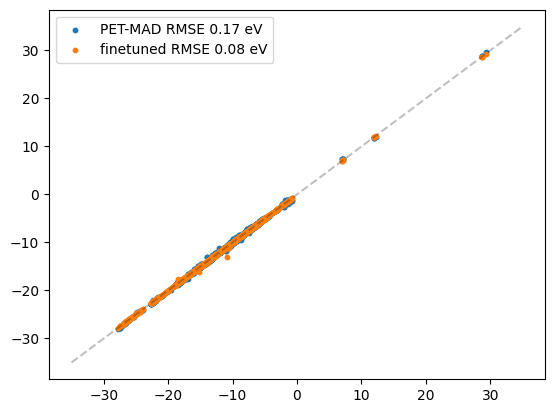

In [7]:
plt.plot([-35,35], [-35,35], '--', color='black', alpha=0.25)
plt.scatter(ref_energies, pet_mad_energies, s=10, label=f'PET-MAD RMSE {np.round(np.sqrt(np.mean((ref_energies - pet_mad_energies)**2)),2)} eV')
plt.scatter(ref_energies, ft_energies, s=10, label=f'finetuned RMSE {np.round(np.sqrt(np.mean((ref_energies - ft_energies)**2)),2)} eV')
plt.legend()


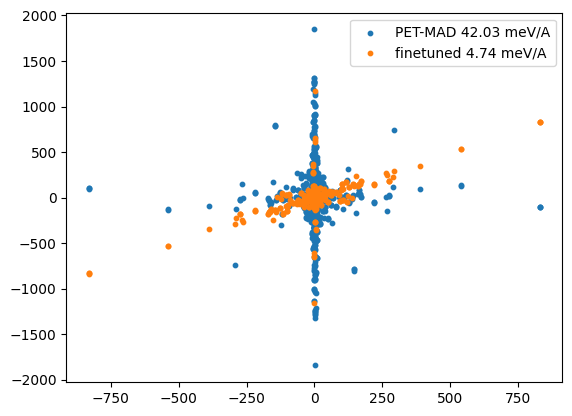

In [8]:
max_x = np.max(ref_forces)#plt.plot([-1500,1500], [-1.5,1.5], '--', color='black', alpha=0.25)
max_y = np.max(ft_forces)
plt.scatter(ref_forces, pet_mad_forces, s=10, label=f'PET-MAD {np.round(np.mean(np.abs(ref_forces-pet_mad_forces)),2)} meV/A')
plt.scatter(ref_forces, ft_forces, s=10, label=f'finetuned {np.round(np.mean(np.abs(ref_forces-ft_forces)),2)} meV/A')
plt.legend()